In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.style.use("seaborn-v0_8-darkgrid")
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=1000, noise=0.15, random_state=64)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

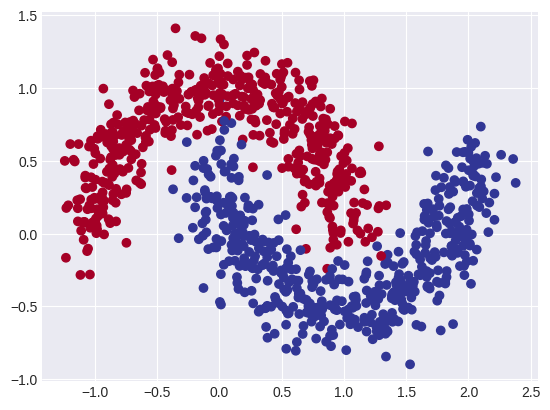

In [4]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [5]:
class MoonsModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.Softplus(),
            nn.Linear(in_features=64, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.Softplus(),
            nn.Linear(in_features=64, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    
    def forward(self, X):
        return self.network.forward(X)

model = MoonsModelV0()

## Overfitting

We have a very large and flexible neural network.

Let's try to train it. We start with a learning rate of 0.5, and from there we can start to go lower and lower. We can re-run the cell and change the learning rate to 0.01 and train again. After a while we will get much lower loss value, and much higher accuracy on the training set. Although accuracy on the testing set will become lower.

In [14]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [15]:
epochs = 10000

for epoch in range(epochs):
    model.train()
    y_logits = model.forward(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

Epoch: 0 | Loss: 0.018746446818113327
Epoch: 1000 | Loss: 0.018729742616415024
Epoch: 2000 | Loss: 0.018713580444455147
Epoch: 3000 | Loss: 0.018698371946811676
Epoch: 4000 | Loss: 0.018683793023228645
Epoch: 5000 | Loss: 0.018669703975319862
Epoch: 6000 | Loss: 0.01865609548985958
Epoch: 7000 | Loss: 0.0186428464949131
Epoch: 8000 | Loss: 0.018629953265190125
Epoch: 9000 | Loss: 0.018617428839206696


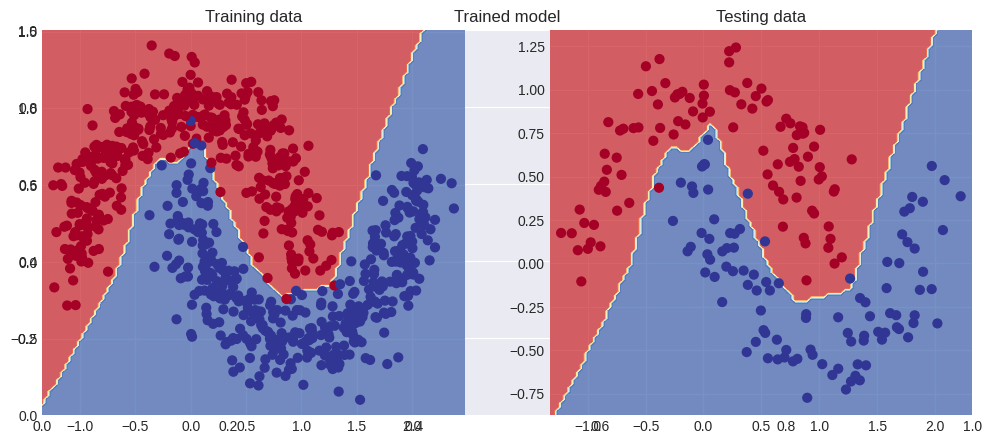

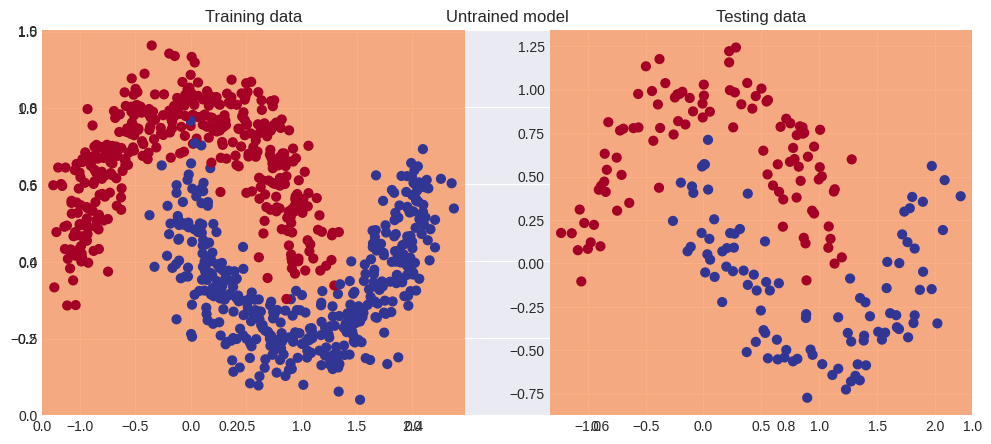

In [16]:
torch.manual_seed(32)
untrained_model = MoonsModelV0()

plt.figure(figsize=(12, 5))
plt.title("Trained model")
plt.subplot(1, 2, 1)
plt.title("Training data")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing data")
plot_decision_boundary(model, X_test, y_test)
plt.show()

plt.figure(figsize=(12, 5))
plt.title("Untrained model")
plt.subplot(1, 2, 1)
plt.title("Training data")
plot_decision_boundary(untrained_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing data")
plot_decision_boundary(untrained_model, X_test, y_test)
plt.show()

In [17]:
from torchmetrics.classification import BinaryAccuracy

metric = BinaryAccuracy()

y_logits = model.forward(X_test).squeeze()
y_pred = torch.round(torch.sigmoid(y_logits))
accuracy_test = metric(y_pred, y_test)

y_logits = model.forward(X_train).squeeze()
y_pred = torch.round(torch.sigmoid(y_logits))
accuracy_train = metric(y_pred, y_train)

print(
    f"Training accuracy: {accuracy_train*100:.2f}%",
    f"Testing accuracy: {accuracy_test*100:.2f}%",
    sep="\n"
)

Training accuracy: 99.50%
Testing accuracy: 98.00%
